This notebook will analyse the effect of having the mic flush or not flush against the wall. 

Now that the speaker playback variation has been solved - I'll also re-analyse the directionality data to see if I can recover the directionality data of the GRAS 1/4". 

notebook initiation date: 2021-06-07

In [1]:
import datetime as dt
import glob
import os
import sys
sys.path.append('../../')
sys.path.append('../')
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import numpy as np 
import pandas as pd
import soundfile as sf
import scipy.signal as signal 
import tqdm

import playback_code
import playback_code.playback_analysis as pa
from fullscale_calculations import *


In [2]:
print(f'This cell was run at: {dt.datetime.now()}')

This cell was run at: 2021-06-07 14:37:52.297094


In [3]:
def calculate_tones_rec_level(audio, fs, tone_freqs, FS_dbu, gain, sensitivity_dbvrms, freq_bw=500):
    '''
    '''
    
    audio_parts = np.array_split(audio, len(tone_freqs))
    
    tones_rms = []
    for peak_freq, tone_part in zip(tone_freqs, audio_parts):
        loudest_inds, _ = get_loudest_part(tone_part, fs=fs)
        audio_part = tone_part[loudest_inds]
        signal_fft = np.fft.fft(audio_part)
        fftfreqs = np.fft.fftfreq(audio_part.size, 1/fs)
        if np.logical_or(peak_freq<=0, peak_freq>=fs*0.5):
            raise ValueError(f'A peakfrequency <0 or > Nyquist frequency ({peak_freq}Hz) has been detected. Aborting....')
        signal_band = np.array([peak_freq-freq_bw, peak_freq+freq_bw])
        signal_band[signal_band<0] = 0
        signal_band[signal_band>fs*0.5] = fs*0.5
        rms_value = pa.extract_bandrms_from_fft(signal_band, signal_fft, fftfreqs)
        tones_rms.append(rms_value)
    
    #tones_rms = pa.get_tones_rms(audio, tone_freqs,fs=fs,bandwidth=freq_bw)
    tones_rms = pd.DataFrame(data={'tone_rms':tones_rms})
    max_rms = 1/(np.sqrt(2)) # for Vp=1 Vrms = (1/sqrt(2))*Vp
    tones_rms['dbrms_re_max'] = pa.dB(tones_rms['tone_rms']/max_rms)
    tones_rms['dbrms_wogain'] = tones_rms['dbrms_re_max']-gain
    tones_rms['db_FS'] = pa.dB(dbu2vrms(FS_dbu))
    tones_rms['tone_db'] = tones_rms['db_FS'] + tones_rms['dbrms_wogain']
    tones_rms['tone_freqs'] = tone_freqs
    sensitivity_vrms = 10**(sensitivity_dbvrms/20.0) # Vrms/Pa
    ref = 20*10**-6 # Pa

    tones_rms['Pa_rms'] = 10**(tones_rms['tone_db']/20.0)*(1/sensitivity_vrms)
    tones_rms['dbspl_rms'] = pa.dB(tones_rms['Pa_rms']/ref)
    return tones_rms


def make_avged_fft(recording_name, fft_dictionary):
    # first check all ffts are the same size 
    fft_sizes = [len(fft_dictionary[recording_name][i][:,1]) for i in range(5)]
    if not np.all(np.array(fft_sizes)==fft_sizes[0]):
        raise ValueError(f'all FFTs not same size: {fft_sizes}')
    all_ffts = np.array([fft_dictionary[recording_name][i][:,1] for i in range(5)]).reshape(5,-1)
    avg_fft = 20*np.log10(np.mean(10**(all_ffts/20.0), axis=0))
    freqs = fft_dictionary[recording_name][0][:,0]
    return avg_fft, freqs

def calculate_average_sweep_spectrum(audio, fs):
    sweeps = np.array_split(audio[int(fs*0.5):int(fs*1.5)],5)

    sweep_ffts = {}

    for i,each in enumerate(sweeps):
        sweeps_bp = signal.lfilter(b,a,each)
        sweepregion, _ = get_loudest_part(sweeps_bp)
        sweep_only = sweeps_bp[sweepregion]
        sweeps_fft = 20*np.log10(np.abs(np.fft.rfft(sweep_only)))
        sweeps_freq = np.fft.rfftfreq(sweep_only.size,1.0/fs)
        sweep_ffts[i] = np.column_stack((sweeps_freq, sweeps_fft))
    # make 'average' sweep spectrum
    avgd_fft, freqs = make_avged_fft('1', {'1':sweep_ffts})
    return freqs, avgd_fft


def get_loudest_part(X, fs=192000, winsize=0.025):
    x_sq = np.sqrt(np.abs(X)**2)
    winsamples = int(fs*winsize)
    running_mean = np.convolve(x_sq, np.ones(winsamples)/winsamples, mode='same')
    threshold = np.percentile(running_mean, [10,90])
    indices = np.logical_and(running_mean >=threshold[0], running_mean>=threshold[1])
    return indices, running_mean

def get_avg_sweep_spectrum(fname):
    audio, fs = sf.read(fname)
    freqs, spectrum = calculate_average_sweep_spectrum(audio, fs)
    return freqs, spectrum


fs = 192000
b,a = signal.butter(2, np.array([9000,95500])/(fs*0.5), 'bandpass')

In [4]:
%matplotlib notebook

In [5]:
audio_recs = glob.glob('../../2021-05-31/*.wav')
audio_recs

['../../2021-05-31\\gras-2mwallnotflush12mm_amp401_speaker504_gaindB_50_azimuth_angle_30_2021-05-31_17-24-57.wav',
 '../../2021-05-31\\gras-2mwallnotflush12mm_amp401_speaker504_gaindB_50_azimuth_angle_60_2021-05-31_17-27-37.wav',
 '../../2021-05-31\\gras-2mwallnotflush12mm_amp401_speaker504_gaindB_50_azimuth_angle_90_2021-05-31_17-29-56.wav',
 '../../2021-05-31\\gras-2mwallnotflush150mm_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-20-50.wav',
 '../../2021-05-31\\gras-2mwallnotflush150mm_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-23-05.wav',
 '../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-16-36.wav',
 '../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-18-39.wav',
 '../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-31-31.wav',
 '../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_30_2021-05-31_17-33-24.wav',
 '../../2021-05-

In [6]:
notflush_recs = [each for each in audio_recs if 'notflush' in each]
flush_recs = list(set(audio_recs)-set(notflush_recs))
flush_recs

['../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-18-39.wav',
 '../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_60_2021-05-31_17-35-03.wav',
 '../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-31-31.wav',
 '../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_90_2021-05-31_17-36-36.wav',
 '../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-16-36.wav',
 '../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_30_2021-05-31_17-33-24.wav']

In [7]:
onaxis_flush_recs = [each for each in flush_recs if 'angle_0_' in each]
onaxis_flush_recs

['../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-18-39.wav',
 '../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-31-31.wav',
 '../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-16-36.wav']

In [8]:
notflush_recs

['../../2021-05-31\\gras-2mwallnotflush12mm_amp401_speaker504_gaindB_50_azimuth_angle_30_2021-05-31_17-24-57.wav',
 '../../2021-05-31\\gras-2mwallnotflush12mm_amp401_speaker504_gaindB_50_azimuth_angle_60_2021-05-31_17-27-37.wav',
 '../../2021-05-31\\gras-2mwallnotflush12mm_amp401_speaker504_gaindB_50_azimuth_angle_90_2021-05-31_17-29-56.wav',
 '../../2021-05-31\\gras-2mwallnotflush150mm_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-20-50.wav',
 '../../2021-05-31\\gras-2mwallnotflush150mm_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-23-05.wav']

In [9]:
onaxis_notflush_recs = [each for each in notflush_recs if 'angle_0_' in each]
onaxis_notflush_recs

['../../2021-05-31\\gras-2mwallnotflush150mm_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-20-50.wav',
 '../../2021-05-31\\gras-2mwallnotflush150mm_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-23-05.wav']

In [10]:
fireface_dbu_FS = 27
gras_dbVrmsPa = -49.17
gras_gain = 50
gras_datasheet_freqs = np.arange(20,90,5)*10**3
freqs = np.arange(10000, 95000, 1000)


In [11]:
flush_onaxis, _ = sf.read(onaxis_flush_recs[0])
tones_flushonaxis = pa.get_only_tones(flush_onaxis, 1.5)
flushonaxis_bp = signal.lfilter(b,a, tones_flushonaxis)
flush_onaxis_spl = calculate_tones_rec_level(flushonaxis_bp, 192000, freqs, fireface_dbu_FS, gras_gain, gras_dbVrmsPa)

In [12]:
notflush_onaxis_tones = pa.get_only_tones(sf.read(onaxis_notflush_recs[0])[0], 1.5)
notflush_bp = signal.lfilter(b,a,notflush_onaxis_tones)
notflush_onaxis_spl = calculate_tones_rec_level(notflush_bp, 192000, freqs, 
                                                        fireface_dbu_FS, gras_gain, gras_dbVrmsPa)

In [13]:
# also compare the flush data from a recording a few days ago 
fname = '../../2021-05-27/'+'gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-27_15-13-29.wav'
audio, _ = sf.read(fname)
tones_bp = signal.lfilter(b,a,pa.get_only_tones(audio, 1.5))
flush_onaxis_spl_4days = calculate_tones_rec_level(tones_bp, 192000, freqs, 
                                                        fireface_dbu_FS, gras_gain, gras_dbVrmsPa)


In [14]:
subset_inds = np.arange(0,freqs.size,20)

<IPython.core.display.Javascript object>


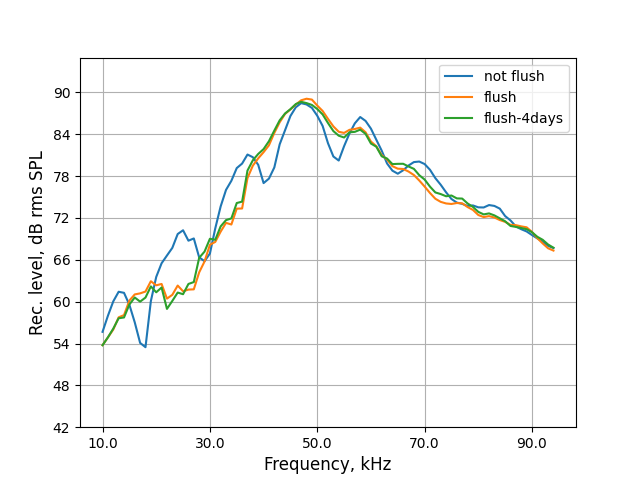

Text(0, 0.5, 'Rec. level, dB rms SPL')

In [15]:
plt.figure()
plt.plot(notflush_onaxis_spl['tone_freqs']*0.001, notflush_onaxis_spl['dbspl_rms'], label='not flush')
plt.plot(flush_onaxis_spl['tone_freqs']*0.001, flush_onaxis_spl['dbspl_rms'], label='flush')
plt.plot(flush_onaxis_spl_4days['tone_freqs']*0.001, flush_onaxis_spl_4days['dbspl_rms'], label='flush-4days')

plt.legend(); plt.ylim(42,95);plt.yticks(np.arange(42,93,6));plt.grid()
plt.xticks(flush_onaxis_spl['tone_freqs'][subset_inds]*0.001, flush_onaxis_spl['tone_freqs'][subset_inds]*0.001)
plt.xlabel('Frequency, kHz', fontsize=12);plt.ylabel('Rec. level, dB rms SPL', fontsize=12)

### There is a clear difference in the recorded playback if the microphone is flush against the wall or not!

### How stable is the speaker playback really??
Let's compare the tone levels from 27/5 and 31/5 for the microphone set flush to the 'wall'


<IPython.core.display.Javascript object>


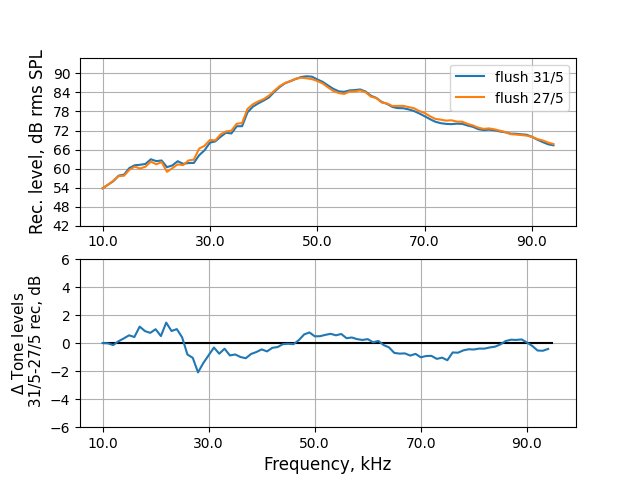

In [16]:
plt.figure()
plt.subplot(211)
plt.plot(flush_onaxis_spl['tone_freqs']*0.001, flush_onaxis_spl['dbspl_rms'], label='flush 31/5')
plt.plot(flush_onaxis_spl_4days['tone_freqs']*0.001, flush_onaxis_spl_4days['dbspl_rms'], label='flush 27/5')
plt.legend(); plt.ylim(42,95);plt.yticks(np.arange(42,93,6));plt.grid()
plt.xticks(flush_onaxis_spl['tone_freqs'][subset_inds]*0.001, flush_onaxis_spl['tone_freqs'][subset_inds]*0.001)
plt.ylabel('Rec. level, dB rms SPL', fontsize=12)
plt.subplot(212)
plt.plot(flush_onaxis_spl_4days['tone_freqs']*0.001, flush_onaxis_spl['dbspl_rms']-flush_onaxis_spl_4days['dbspl_rms'], label='flush-2days')
plt.hlines(0,10,95,'k');plt.ylim(-6,6);plt.grid()
plt.xlabel('Frequency, kHz', fontsize=12);plt.ylabel('$\Delta$ Tone levels \n 31/5-27/5 rec, dB', fontsize=11)
plt.xticks(flush_onaxis_spl['tone_freqs'][subset_inds]*0.001, flush_onaxis_spl['tone_freqs'][subset_inds]*0.001);


### There is still some inter-day playback variation in the tones. 
Despite best efforts, the tones seem to still show inter-day variation. As far as I remember, the experiments on 31/5 and 27/5 had restraint points on the tripod base to standardise the speaker playback directions. There still seems to be a variation of max $\pm 4$ dB. 

### Is there less variation in the sweep levels? 

In [17]:
onaxis_flush_recs

['../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-18-39.wav',
 '../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-31-31.wav',
 '../../2021-05-31\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-31_17-16-36.wav']

In [18]:
sweep_freqs, flush_31may1 = get_avg_sweep_spectrum(onaxis_flush_recs[0])
sweep_freqs, flush_31maylast = get_avg_sweep_spectrum(onaxis_flush_recs[-1])
sweep_freqs, flush_27may = get_avg_sweep_spectrum(fname)

<IPython.core.display.Javascript object>


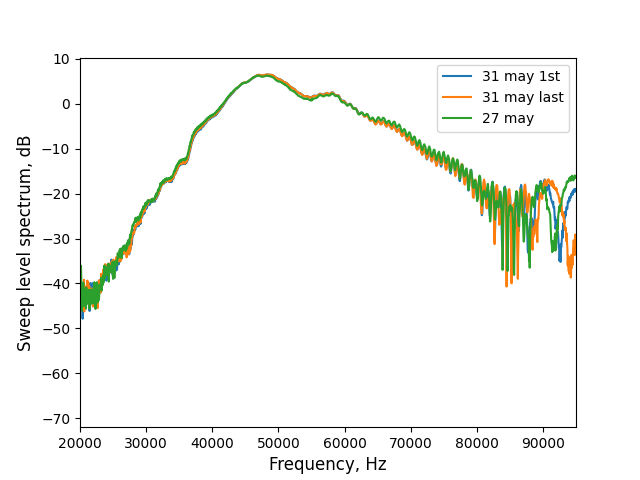

In [19]:
plt.figure()
plt.plot(sweep_freqs, flush_31may1, label='31 may 1st');
plt.plot(sweep_freqs, flush_31maylast, label='31 may last');
plt.plot(sweep_freqs, flush_27may, label='27 may ');
plt.xlim(20000, 95000);plt.ylabel('Sweep level spectrum, dB', fontsize=12);plt.xlabel('Frequency, Hz', fontsize=12)
plt.legend()

In [20]:
norm_to_max = lambda X: np.max(X)-X

<IPython.core.display.Javascript object>


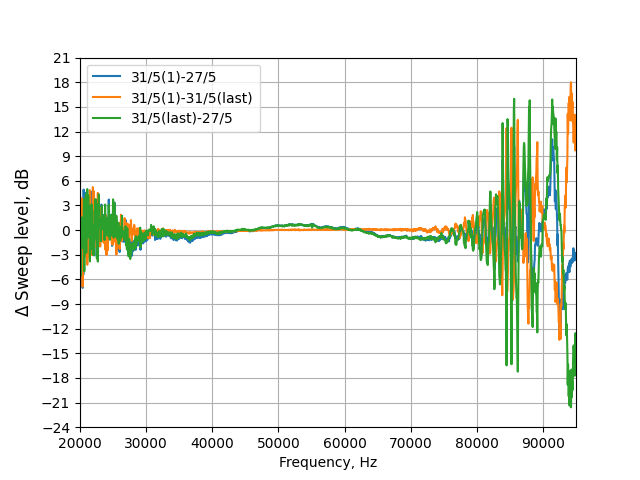

In [21]:
plt.figure()
plt.plot(sweep_freqs,flush_31may1-flush_27may, label='31/5(1)-27/5');
plt.plot(sweep_freqs, flush_31may1-flush_31maylast, label='31/5(1)-31/5(last)');
plt.plot(sweep_freqs,flush_31maylast-flush_27may, label='31/5(last)-27/5');
plt.xlim(20000, 95000);plt.legend();plt.ylabel('$\Delta$ Sweep level, dB', fontsize=12)
plt.xlabel('Frequency, Hz');plt.yticks(np.arange(-24,24,3));plt.grid()

### Tone playback levels are more stable than sweeps. 

Sweep playback levels are constant only between 30-80 kHz (<3dB variation), beyond which they fluctuate wildly - this might however also just be because 

In [22]:
print(f'This cell was run at: {dt.datetime.now()}')

This cell was run at: 2021-06-07 14:38:05.499206
